    Ben Christensen
    Math 403
    9/17/18

Gather information from a json file. Write a Tic-tac-toe game that uses a client and server.

In [1]:
import json
import socket
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
from textwrap import wrap
import random

In [2]:
# Problem 1
def prob1(filename="nyc_traffic.json"):
    """Load the data from the specified JSON file. Look at the first few
    entries of the dataset and decide how to gather information about the
    cause(s) of each accident. Make a readable, sorted bar chart showing the
    total number of times that each of the 7 most common reasons for accidents
    are listed in the data set.
    """
    with open(filename, 'r') as infile:
        accidents = json.load(infile)

    #Create a set for all the accident reasons
    accident_reasons = set()
    for accident in accidents:
        try:
            accident_reasons.add(accident["contributing_factor_vehicle_1"])
        except Exception as e:
            pass
        try:
            accident_reasons.add(accident["contributing_factor_vehicle_2"])
        except Exception as e:
            pass

    #Count the number of instances for each accident reason
    count = Counter()
    for reason in accident_reasons:
        for accident in accidents:
            try:
                if accident["contributing_factor_vehicle_1"] == reason:
                    count[reason] += 1
            except Exception as e:
                pass
            try:
                if accident["contributing_factor_vehicle_2"] == reason:
                    count[reason] += 1
            except Exception as e:
                pass
    #Find the number of missing contributing factors in the data
    missing_vehicle_1_factors = 0
    missing_vehicle_2_factors = 0
    for accident in accidents:
        try:
            if accident["contributing_factor_vehicle_1"] == reason:
                pass
        except Exception as e:
            missing_vehicle_1_factors += 1
        try:
            if accident["contributing_factor_vehicle_2"] == reason:
                pass
        except Exception as e:
            missing_vehicle_2_factors += 1

    names = []
    freq = []
    commons = count.most_common(7)
    for common in commons:
        names.append(common[0])
        freq.append(common[1])

    #Plot the top 7 reasons for accidents
    plt.barh(names[::-1],freq[::-1])
    plt.title("\n".join(wrap("Most Common Reason for Accidents in NYC Summer 2017", 60)))
    plt.xlabel("Number of accidents")
    plt.ylabel("Reason for Accident")
    plt.tight_layout(1)
    plt.show()


class TicTacToe:
    def __init__(self):
        """Initialize an empty board. The O's go first."""
        self.board = [[' ']*3 for _ in range(3)]
        self.turn, self.winner = "O", None

    def move(self, i, j):
        """Mark an O or X in the (i,j)th box and check for a winner."""
        if self.winner is not None:
            raise ValueError("the game is over!")
        elif self.board[i][j] != ' ':
            raise ValueError("space ({},{}) already taken".format(i,j))
        self.board[i][j] = self.turn

        # Determine if the game is over.
        b = self.board
        if any(sum(s == self.turn for s in r)==3 for r in b):
            self.winner = self.turn     # 3 in a row.
        elif any(sum(r[i] == self.turn for r in b)==3 for i in range(3)):
            self.winner = self.turn     # 3 in a column.
        elif b[0][0] == b[1][1] == b[2][2] == self.turn:
            self.winner = self.turn     # 3 in a diagonal.
        elif b[0][2] == b[1][1] == b[2][0] == self.turn:
            self.winner = self.turn     # 3 in a diagonal.
        else:
            self.turn = "O" if self.turn == "X" else "X"

    def empty_spaces(self):
        """Return the list of coordinates for the empty boxes."""
        return [(i,j) for i in range(3) for j in range(3)
                                        if self.board[i][j] == ' ' ]
    def __str__(self):
        return "\n---------\n".join(" | ".join(r) for r in self.board)


# Problem 2
class TicTacToeEncoder(json.JSONEncoder):
    """A custom JSON Encoder for TicTacToe objects."""
    def default(self, obj):
        if not isinstance(obj, TicTacToe):
            raise TypeError("expected a TicTacToe Object for encoding")
        return {"dtype": "TicTacToe", "board": obj.board, "turn": obj.turn, "winner": obj.winner}




# Problem 2
def tic_tac_toe_decoder(obj):
    """A custom JSON decoder for TicTacToe objects."""
    if "dtype" in obj:
        if obj["dtype"] != "TicTacToe" or "board" not in obj or "turn" not in obj or "winner" not in obj:
            raise ValueError("expected a tic tac toe message")
        new_board = TicTacToe()
        new_board.board = obj["board"]
        new_board.turn = obj["turn"]
        new_board.winner = obj["winner"]
        return new_board
    raise ValueError("expected a tic tac toe message")


def mirror_server(server_address=("0.0.0.0", 33333)):
    """A server for reflecting strings back to clients in reverse order."""
    print("Starting mirror server on {}".format(server_address))

    # Specify the socket type, which determines how clients will connect.
    server_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_sock.bind(server_address)    # Assign this socket to an address.
    server_sock.listen(1)               # Start listening for clients.

    while True:
        # Wait for a client to connect to the server.
        print("\nWaiting for a connection...")
        connection, client_address = server_sock.accept()

        try:
            # Receive data from the client.
            print("Connection accepted from {}.".format(client_address))
            in_data = connection.recv(1024).decode()    # Receive data.
            print("Received '{}' from client".format(in_data))

            # Process the received data and send something back to the client.
            out_data = in_data[::-1]
            print("Sending '{}' back to the client".format(out_data))
            connection.sendall(out_data.encode())       # Send data.

        # Make sure the connection is closed securely.
        finally:
            connection.close()
            print("Closing connection from {}".format(client_address))

def mirror_client(server_address=("0.0.0.0", 33333)):
    """A client program for mirror_server()."""
    print("Attempting to connect to server at {}...".format(server_address))

    # Set up the socket to be the same type as the server.
    client_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_sock.connect(server_address)    # Attempt to connect to the server.
    print("Connected!")

    # Send some data from the client user to the server.
    out_data = input("Type a message to send: ")
    client_sock.sendall(out_data.encode())              # Send data.

    # Wait to receive a response back from the server.
    in_data = client_sock.recv(1024).decode()           # Receive data.
    print("Received '{}' from the server".format(in_data))

    # Close the client socket.
    client_sock.close()


# Problem 3
port_num = 1024
def tic_tac_toe_server(server_address=("0.0.0.0", 44444)):
    """A server for playing tic-tac-toe with random moves."""
    print("Starting tic tac toe server on {}".format(server_address))

    # Specify the socket type, which determines how clients will connect.
    server_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server_sock.bind(server_address)
    server_sock.listen(1)



    while True:
        try:
            # Wait for a client to connect to the server.
            print("\nWaiting for a connection...")
            connection, client_address = server_sock.accept()
            print("Connection accepted from {}.".format(client_address))
            while True:
                #Receive data from the client.
                in_data = connection.recv(port_num).decode()
                print("Received '{}' from client".format(in_data))

                #Process the received data and send something back to the client.
                board = json.loads(in_data, object_hook=tic_tac_toe_decoder)
                if board.winner == "O":
                    print("Sending '{}' back to the client".format("Game Result"))
                    connection.sendall("WIN".encode())
                    break
                #Check if the board is full
                board_full = True
                for row in board.board:
                    for entry in row:
                        if entry == " ":
                            board_full = False
                            break
                    if board_full is False:
                        break

                if board.winner is None and board_full is True:
                    print("Sending '{}' back to the client".format("Game Result"))
                    connection.sendall("DRAW".encode())
                    break
                #Make a random move (that is also valid)
                else:
                    valid_coordinate = False
                    while valid_coordinate is False:
                        coordinates = (random.randint(0,2), random.randint(0,2))
                        valid_coordinate = coordinates in board.empty_spaces()

                    board.move(coordinates[0], coordinates[1])
                    #Client Lost. Send back results
                    if board.winner is not None:
                        print("Sending '{}' back to the client".format("Game Result"))
                        connection.sendall("LOSE".encode())
                        encoded_board = json.dumps(board,cls=TicTacToeEncoder)
                        print("Sending '{}' back to the client".format(encoded_board))
                        connection.sendall(encoded_board.encode())
                        break

                    encoded_board = json.dumps(board, cls=TicTacToeEncoder)
                    print("Sending '{}' back to the friggin client".format(encoded_board))
                    connection.sendall(encoded_board.encode())

        finally:
            connection.close()
            print("Closing connection from {}".format(client_address))

# Problem 4
def tic_tac_toe_client(server_address=("0.0.0.0", 44444)):
    """A client program for tic_tac_toe_server()."""
    print("Attempting to connect to server at {}...".format(server_address))

    #Set up the socket to be the same type as the server.
    client_sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    client_sock.connect(server_address)
    game = TicTacToe()

    while game.winner is None:
        print(game)
        valid_move = False
        #Check if it's a valid move
        while valid_move is False:
            #Check if input is a number
            not_int = True
            while not_int is True:
                not_int = False
                try:
                    x = int(input("Please enter the row you wish to move:"))
                    y = int(input("Please enter the column you wish to move:"))
                except Exception as e:
                    print("You must enter a number")
                    not_int = True
            #Perform valid move
            coordinates = [x,y]
            if coordinates[0] not in range(0,3) or coordinates[1] not in range(0,3):
                print("Each coordinate must take the values 0, 1, or 2")
            elif game.board[coordinates[0]][coordinates[1]] != " ":
                print("You cannot move there. That position is occupied.")
            else:
                valid_move = True
                game.move(coordinates[0], coordinates[1])

        encoded_board = json.dumps(game, cls=TicTacToeEncoder)
        print("Sending '{}' to the server".format(encoded_board))
        client_sock.sendall(encoded_board.encode())

        # Wait to receve a response back from the server
        in_data = client_sock.recv(port_num).decode()
        print("Received '{}' from the server".format(in_data))
        if in_data == "DRAW":
            print("It's a draw! Mwahahaha")
            break

        elif in_data == "WIN":
            print("You are the winner. I am the loser.")
            break
        elif in_data == "LOSE":
            print("You are the loser. I am the winner.")
            in_data = client_sock.recv(port_num).decode()
            #Receive the tic tac toe object
            game = json.loads(in_data, object_hook=tic_tac_toe_decoder)
            print(game)
            break
        game = json.loads(in_data, object_hook=tic_tac_toe_decoder)

    #Close the client socket.
    client_sock.close()





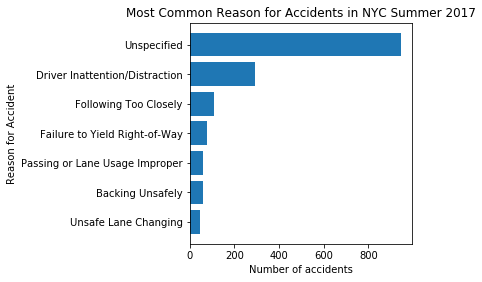

In [3]:
filename = "/Users/benchristensen/Desktop/ACME Python Labs/Volume3/WebTechnologies/nyc_traffic.json"
prob1(filename)